In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf

In [2]:
# anulo el uso de la GPU por falta de memoria
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0' #'-1' for no GPU

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# No GPU found

# tf.enable_eager_execution()
tf.VERSION

GPU found


'1.13.1'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2

from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
import keras.backend as K

from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train


DATA_PATH = "data"

Using TensorFlow backend.


In [4]:
import os
print(os.listdir("data"))

['results_df_20190710232755.pkl', 'results_test_df_20190710232755.pkl', 'processed_train_images', 'results_df_20190711090031.pkl', 'results_test_models_df_20190711111832.pkl', 'results_test_model2_df_20190715101522.pkl', 'results_test_model2_df_20190716114127.pkl', 'results_test_df_20190712001832.pkl', 'train.csv', 'results_df.pkl', 'train_images', 'test.csv', 'test_images', 'results_test_df_20190711090031.pkl', 'processed_test_images', 'results_test_df.pkl', 'sample_submission.csv', 'results_df_20190712001832.pkl', 'results_test_model2_df_20190711111855.pkl', 'results_test_model2_df_20190712083607.pkl']


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10050347624680931996
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14300830807521021745
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1759101704449704698
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7282334106
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17134733229018914076
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# 1. Introduction. Explore first, train later.

Hi everyone! As *Aravind Eye Hospital* is one of my favorite organization in the world; they take care of poor people's eyes for free with an impressive sustainable business model.  I will try my best to contribute something to our community. One intuitive way to improve the performance of our model is to simply improve the quality of input images. In this kernel, I will share two ideas which I hope may be useful to some of you : 

- **Decolorize images** : here as we will see, images come with many different lighting conditions, some images are quite dark and difficult to visualize. We can try to convert the image to gray scale, and visualize better. Alternatively, we can try the method of [Ben Graham (last competition's winner)](https://github.com/btgraham/SparseConvNet/tree/kaggle_Diabetic_Retinopathy_competition)
- **Cropping uninformative area** : everyone know this :) Here, I just find the codes from internet and choose the best one for you :)

We are going to apply both techniques to both the official data, and the past competition data (shout out @tanlikesmath for creating this dataset! https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resized . In the updated version, I also try @donkeys' dataset https://www.kaggle.com/donkeys/retinopathy-train-2015 , which is .png which may be have higer image quality than .jpeg format)

If I found more useful tricks, I will update the notebook, or if you have more useful tricks and would love to share, please let me know!

I use some parts of codes from @mathormad and @artgor kernels. Thanks both of you!

Now let us start by loading the train/test dataframes. The `train_test_split` here is in fact not necessary. But when I first fork the kernel from @mathormad, I found some interesting examples using this split and the current `SEED`, so I continue to use them here.

In [6]:
df_train = pd.read_csv(DATA_PATH + '/train.csv')
df_test = pd.read_csv(DATA_PATH + '/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)


(3662,) (3662,)


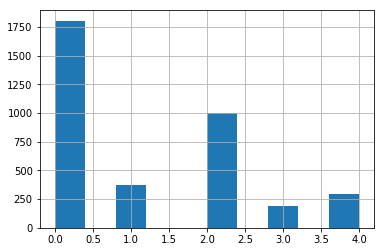

In [7]:
print(x.shape,  y.shape)
y.hist()

In [8]:
print(df_train.groupby('diagnosis').count())

           id_code
diagnosis         
0             1805
1              370
2              999
3              193
4              295


## 1.1 Simple picture to explain Diabetic Retinopathy

How do we know that a patient have diabetic retinopahy? There are 5 things to spot on. Image credit https://www.eyeops.com/
![credit : https://www.eyeops.com/](https://sa1s3optim.patientpop.com/assets/images/provider/photos/1947516.jpeg)

From quick investigations of the data (see various pictures below), I found that *Hemorrphages, Hard Exudates and Cotton Wool spots* are quite easily observed. However, I still could not find examples of *Aneurysm* or *Abnormal Growth of Blood Vessels* from our data yet. Perhaps the latter two cases are important if we want to catch up human benchmnark using our model.

## Process Dataset

In [9]:
def crop_image1(img,tol=8):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

In [10]:
def enhance(image, clip_limit=3, GaussFilter = True, size=(400,500)):
    # convert image to LAB color model
    
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # split the image into L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(image_lab)

    # apply CLAHE to lightness channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L channel with the original A and B channel
    merged_channels = cv2.merge((cl, a_channel, b_channel))

    # convert iamge from LAB color model back to RGB color model
    image = cv2.cvtColor(merged_channels, cv2.COLOR_LAB2BGR)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Auto Crop image
    cropped_image = crop_image1(image_gray, 8)
    
    # resize image
    resized_image = cv2.resize(cropped_image, size)
    # Include Ben Graham preprocessing (-4 value)
    if GaussFilter:
        final_image=cv2.addWeighted ( resized_image,4, 
                                     cv2.GaussianBlur( resized_image , (0,0) , IMG_SIZE/10) ,-4 ,128)
        return final_image
    else:
        return resized_image

In [11]:
import tqdm
# Aquí transcribimos las imágenes a un fichero tipo TFRECORD de tamaño
# el primer modelo usaba imágenes de 100x125
width = 200 # 400
height = 250 # 500

size = (width,height)

image_x = []

for i in tqdm.tqdm(x):
    path=f"/mnt/DATA-SSD/DataSandbox/APTOS/train_images/{i}.png"
    image = cv2.imread(path)
    enhanced_image = enhance(image,2, False, size)
    # img = image.img_to_array(enhanced_image)
    img = enhanced_image.reshape((width, height, 1))/255
    image_x.append(img)

X = np.array(image_x)



100%|██████████| 3662/3662 [04:46<00:00, 12.77it/s]


NameError: name 'y1' is not defined

In [12]:
Y = to_categorical(y)

In [13]:
print(len(x), X.shape)
print(len(Y), Y.shape)
print(np.amax(X))

3662 (3662, 200, 250, 1)
3662 (3662, 5)
1.0


# The Model
## inspired in real life

help obtained from
https://machinelearningmastery.com/keras-functional-api-deep-learning/


In [14]:
# ---------------------
# OPTION 3
# model with two processing routes with different receptive fields size (kernel sizes)
# ---------------------
''' '''

input_layer = tf.keras.Input(shape=(width,height,1))
print('input_layer: ', input_layer.shape)

layer1a = tf.keras.layers.Conv2D(128, kernel_size=(1, 1), activation='relu')(input_layer)
print('layer: ', layer1a.shape)

layer1b = tf.keras.layers.Conv2D(128, kernel_size=(10, 10), activation='relu')(input_layer)
print('layer: ', layer1b.shape)

layer2a = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(layer1a)
print('layer: ', layer2a.shape)

layer2b = tf.keras.layers.Conv2D(64, kernel_size=(10, 10), activation='relu')(layer1b)
print('layer: ', layer2b.shape)

layer3a = tf.keras.layers.Conv2D(32, kernel_size=(2, 2), activation='relu')(layer2a)
print('layer: ', layer3a.shape)

layer3b = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(layer2b)
print('layer: ', layer3b.shape)

layer4a = tf.keras.layers.MaxPooling2D(pool_size=(3, 3))(layer3a)
print('layer: ', layer3a.shape)

layer4b = tf.keras.layers.MaxPooling2D(pool_size=(3, 3))(layer3b)
print('layer: ', layer3b.shape)

layer5a = tf.keras.layers.Flatten()(layer4a)
print('layer: ', layer4a.shape)

layer5b = tf.keras.layers.Flatten()(layer4b)
print('layer: ', layer4b.shape)

layer6 = tf.keras.layers.concatenate([layer5a, layer5b])

layer7 = tf.keras.layers.Dense(10*NUM_CLASSES, activation='relu')(layer6)
print('layer: ', layer6.shape)

layer8 = tf.keras.layers.Dense(5*NUM_CLASSES, activation='relu')(layer7)
print('layer: ', layer6.shape)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(layer8)
print('output_layer: ', output_layer.shape)

model = tf.keras.Model(inputs = [input_layer], outputs = [output_layer])



input_layer:  (?, 200, 250, 1)
Instructions for updating:
Colocations handled automatically by placer.
layer:  (?, 200, 250, 128)
layer:  (?, 191, 241, 128)
layer:  (?, 198, 248, 64)
layer:  (?, 182, 232, 64)
layer:  (?, 197, 247, 32)
layer:  (?, 180, 230, 32)
layer:  (?, 197, 247, 32)
layer:  (?, 180, 230, 32)
layer:  (?, 65, 82, 32)
layer:  (?, 60, 76, 32)
layer:  (?, 316480)
layer:  (?, 316480)
output_layer:  (?, 5)


In [15]:
# import pydot
# import graphviz

print(model.summary())
# no va por alguna chuminada
# tf.keras.utils.plot_model(model, 'model.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 250, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 250, 128 256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 191, 241, 128 12928       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 198, 248, 64) 73792       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_3 (

In [16]:
# model.compile(optimizer=tf.train.AdamOptimizer(),
#              loss = tf.keras.losses.CategoricalCrossentropy())

#
# Next sytep is to include parameters to optimizer and change optimizer
#

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [ ]:
import datetime
# este es el modelo estándar, con la entrada y la salida esperadas
# hay que sustituirlo por un iterador.


# No olvidarse de incluir un train_history para recuperar los datos del entrenamiento
# 5000 epochs es una locura y el número de steps per epoch es muy bajo (no se recorren todas las imagenes)
# el mínimo steps_per_epoch debería de ser total_muestras/batch_size

lt = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

model_file = "/mnt/DATA-SSD/DataSandbox/APTOS/model_" + lt + "_{epoch:04d}.h5"

# with callback
train_history = model.fit(X, Y,
                          batch_size = 10,
                          epochs=2000,
                          verbose=1,
                          shuffle = True,
                          callbacks = [tf.keras.callbacks.ModelCheckpoint(model_file, 
                                                                          save_weights_only = False,
                                                                          verbose=1,
                                                                          period=50)])

Instructions for updating:
Use tf.cast instead.
Epoch 1/2000
3662/3662 [==============================] - 107s 29ms/sample - loss: 0.8940 - acc: 0.6780
Epoch 2/2000
3662/3662 [==============================] - 102s 28ms/sample - loss: 0.8123 - acc: 0.7054
Epoch 3/2000
3662/3662 [==============================] - 102s 28ms/sample - loss: 0.7776 - acc: 0.7127
Epoch 4/2000
3662/3662 [==============================] - 103s 28ms/sample - loss: 0.7471 - acc: 0.7187
Epoch 5/2000
3662/3662 [==============================] - 102s 28ms/sample - loss: 0.7105 - acc: 0.7414
Epoch 6/2000
3662/3662 [==============================] - 102s 28ms/sample - loss: 0.6615 - acc: 0.7551
Epoch 7/2000
3662/3662 [==============================] - 102s 28ms/sample - loss: 0.5968 - acc: 0.7845
Epoch 8/2000
3662/3662 [==============================] - 101s 28ms/sample - loss: 0.5107 - acc: 0.8143
Epoch 9/2000
3662/3662 [==============================] - 99s 27ms/sample - loss: 0.4199 - acc: 0.8474
Epoch 10/2000
366

3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0259 - acc: 0.9872
Epoch 76/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0423 - acc: 0.9814
Epoch 77/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0252 - acc: 0.9855
Epoch 78/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0237 - acc: 0.9863
Epoch 79/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0244 - acc: 0.9869
Epoch 80/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0404 - acc: 0.9825
Epoch 81/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0329 - acc: 0.9847
Epoch 82/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0291 - acc: 0.9842
Epoch 83/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0356 - acc: 0.9836
Epoch 84/2000
3662/3662 [==============================] - 97s 26ms/sample - l

3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0403 - acc: 0.9817
Epoch 151/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0225 - acc: 0.9858
Epoch 152/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0185 - acc: 0.9877
Epoch 153/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0189 - acc: 0.9872
Epoch 154/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0179 - acc: 0.9883
Epoch 155/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0179 - acc: 0.9872
Epoch 156/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0180 - acc: 0.9874
Epoch 157/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0185 - acc: 0.9869
Epoch 158/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0212 - acc: 0.9858
Epoch 159/2000
3662/3662 [==============================] - 97s 26ms/s

3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0185 - acc: 0.9883
Epoch 227/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0187 - acc: 0.9877
Epoch 228/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0210 - acc: 0.9877
Epoch 229/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0229 - acc: 0.9872
Epoch 230/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0188 - acc: 0.9869
Epoch 231/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0174 - acc: 0.9869
Epoch 232/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0243 - acc: 0.9842
Epoch 233/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0393 - acc: 0.9820
Epoch 234/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0478 - acc: 0.9828
Epoch 235/2000
3662/3662 [==============================] - 97s 26ms/s

Epoch 301/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0213 - acc: 0.9874
Epoch 302/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0308 - acc: 0.9853
Epoch 303/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0271 - acc: 0.9847
Epoch 304/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0235 - acc: 0.9863
Epoch 305/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0216 - acc: 0.9863
Epoch 306/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0213 - acc: 0.9877
Epoch 307/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0210 - acc: 0.9874
Epoch 308/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0213 - acc: 0.9869
Epoch 309/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0212 - acc: 0.9863
Epoch 310/2000
3662/3662 [=============================

3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0192 - acc: 0.9861
Epoch 378/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0187 - acc: 0.9863
Epoch 379/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0188 - acc: 0.9877
Epoch 380/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0189 - acc: 0.9866
Epoch 381/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0192 - acc: 0.9861
Epoch 382/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0381 - acc: 0.9831
Epoch 383/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0389 - acc: 0.9844
Epoch 384/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0222 - acc: 0.9869
Epoch 385/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0173 - acc: 0.9869
Epoch 386/2000
3662/3662 [==============================] - 97s 26ms/s

3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0165 - acc: 0.9872
Epoch 452/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0165 - acc: 0.9872
Epoch 453/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0166 - acc: 0.9866
Epoch 454/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0163 - acc: 0.9855
Epoch 455/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0165 - acc: 0.9874
Epoch 456/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0166 - acc: 0.9869
Epoch 457/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0168 - acc: 0.9891
Epoch 458/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0169 - acc: 0.9855
Epoch 459/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0166 - acc: 0.9888
Epoch 460/2000
3662/3662 [==============================] - 97s 26ms/s

3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0302 - acc: 0.9861
Epoch 528/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0254 - acc: 0.9858
Epoch 529/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0177 - acc: 0.9872
Epoch 530/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0200 - acc: 0.9880
Epoch 531/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0193 - acc: 0.9877
Epoch 532/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0175 - acc: 0.9872
Epoch 533/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0172 - acc: 0.9877
Epoch 534/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0176 - acc: 0.9877
Epoch 535/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0170 - acc: 0.9885
Epoch 536/2000
3662/3662 [==============================] - 97s 26ms/s

3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0159 - acc: 0.9877
Epoch 602/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0160 - acc: 0.9872
Epoch 603/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0161 - acc: 0.9869
Epoch 604/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0162 - acc: 0.9880
Epoch 605/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0163 - acc: 0.9894
Epoch 606/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0162 - acc: 0.9872
Epoch 607/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0160 - acc: 0.9883
Epoch 608/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0183 - acc: 0.9872
Epoch 609/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0272 - acc: 0.9847
Epoch 610/2000
3662/3662 [==============================] - 97s 26ms/s

3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0463 - acc: 0.9853
Epoch 678/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0203 - acc: 0.9885
Epoch 679/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0198 - acc: 0.9880
Epoch 680/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0196 - acc: 0.9896
Epoch 681/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0196 - acc: 0.9880
Epoch 682/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0196 - acc: 0.9885
Epoch 683/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0197 - acc: 0.9883
Epoch 684/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0196 - acc: 0.9883
Epoch 685/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0200 - acc: 0.9891
Epoch 686/2000
3662/3662 [==============================] - 97s 26ms/s

3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0157 - acc: 0.9880
Epoch 752/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0200 - acc: 0.9866
Epoch 753/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0206 - acc: 0.9866
Epoch 754/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0167 - acc: 0.9883
Epoch 755/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0161 - acc: 0.9885
Epoch 756/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0153 - acc: 0.9888
Epoch 757/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0153 - acc: 0.9885
Epoch 758/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0151 - acc: 0.9869
Epoch 759/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0159 - acc: 0.9874
Epoch 760/2000
3662/3662 [==============================] - 97s 26ms/s

3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0217 - acc: 0.9869
Epoch 828/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0268 - acc: 0.9866
Epoch 829/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0184 - acc: 0.9872
Epoch 830/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0165 - acc: 0.9888
Epoch 831/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0156 - acc: 0.9885
Epoch 832/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0160 - acc: 0.9880
Epoch 833/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0158 - acc: 0.9885
Epoch 834/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0160 - acc: 0.9880
Epoch 835/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0157 - acc: 0.9883
Epoch 836/2000
3662/3662 [==============================] - 97s 26ms/s

3662/3662 [==============================] - 102s 28ms/sample - loss: 0.0330 - acc: 0.9872
Epoch 902/2000
3662/3662 [==============================] - 101s 28ms/sample - loss: 0.0160 - acc: 0.9880
Epoch 903/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0160 - acc: 0.9891
Epoch 904/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0158 - acc: 0.9891
Epoch 905/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0156 - acc: 0.9891
Epoch 906/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0158 - acc: 0.9885
Epoch 907/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0157 - acc: 0.9883
Epoch 908/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0157 - acc: 0.9880
Epoch 909/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0159 - acc: 0.9885
Epoch 910/2000
3662/3662 [==============================] - 97s 26ms

3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0155 - acc: 0.9891
Epoch 978/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0161 - acc: 0.9877
Epoch 979/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0164 - acc: 0.9877
Epoch 980/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0369 - acc: 0.9858
Epoch 981/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0301 - acc: 0.9855
Epoch 982/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0205 - acc: 0.9883
Epoch 983/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0157 - acc: 0.9888
Epoch 984/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0166 - acc: 0.9869
Epoch 985/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0157 - acc: 0.9874
Epoch 986/2000
3662/3662 [==============================] - 97s 26ms/s

3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0154 - acc: 0.9885
Epoch 1052/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0181 - acc: 0.9872
Epoch 1053/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0257 - acc: 0.9888
Epoch 1054/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0314 - acc: 0.9872
Epoch 1055/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0166 - acc: 0.9874
Epoch 1056/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0158 - acc: 0.9877
Epoch 1057/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0155 - acc: 0.9899
Epoch 1058/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0156 - acc: 0.9888
Epoch 1059/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0156 - acc: 0.9880
Epoch 1060/2000
3662/3662 [==============================] - 9

3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0199 - acc: 0.9874
Epoch 1127/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0200 - acc: 0.9891
Epoch 1128/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0199 - acc: 0.9888
Epoch 1129/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0201 - acc: 0.9888
Epoch 1130/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0200 - acc: 0.9885
Epoch 1131/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0200 - acc: 0.9891
Epoch 1132/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0201 - acc: 0.9891
Epoch 1133/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0205 - acc: 0.9888
Epoch 1134/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0204 - acc: 0.9872
Epoch 1135/2000
3662/3662 [==============================] - 9

Epoch 1201/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0494 - acc: 0.9844
Epoch 1202/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0344 - acc: 0.9872
Epoch 1203/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0261 - acc: 0.9883
Epoch 1204/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0247 - acc: 0.9891
Epoch 1205/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0246 - acc: 0.9891
Epoch 1206/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0248 - acc: 0.9872
Epoch 1207/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0245 - acc: 0.9888
Epoch 1208/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0247 - acc: 0.9885
Epoch 1209/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0248 - acc: 0.9885
Epoch 1210/2000
3662/3662 [===================

3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0249 - acc: 0.9885
Epoch 1277/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0248 - acc: 0.9877
Epoch 1278/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0249 - acc: 0.9883
Epoch 1279/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0249 - acc: 0.9877
Epoch 1280/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0249 - acc: 0.9888
Epoch 1281/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0249 - acc: 0.9874
Epoch 1282/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0248 - acc: 0.9885
Epoch 1283/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0247 - acc: 0.9883
Epoch 1284/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0247 - acc: 0.9894
Epoch 1285/2000
3662/3662 [==============================] - 9

3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0373 - acc: 0.9883
Epoch 1351/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0334 - acc: 0.9874
Epoch 1352/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0197 - acc: 0.9894
Epoch 1353/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0193 - acc: 0.9907
Epoch 1354/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0192 - acc: 0.9891
Epoch 1355/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0193 - acc: 0.9904
Epoch 1356/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0193 - acc: 0.9894
Epoch 1357/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0197 - acc: 0.9891
Epoch 1358/2000
3662/3662 [==============================] - 97s 26ms/sample - loss: 0.0197 - acc: 0.9883
Epoch 1359/2000
3662/3662 [==============================] - 9

In [ ]:
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# saves train history as a json file
import json

lt = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
with open(f"/mnt/DATA-SSD/DataSandbox/APTOS/train_history_{lt}.json", 'w') as th_file:
        json.dump(train_history.history, th_file)

In [ ]:
results_train = {}
for i in tqdm.tqdm(df_train.iterrows()):
    path=f"/mnt/DATA-SSD/DataSandbox/APTOS/train_images/{i[1][0]}.png"
    image = cv2.imread(path)
    enhanced_image = enhance(image,2, True, size)
    # img = image.img_to_array(enhanced_image)
    img = enhanced_image.reshape((1,width, height, 1))/255
    results_train[i[0]] = [i[1][0], i[1][1], model.predict(img)]

In [ ]:
results_df = pd.DataFrame.from_dict(results_train, 
                                    orient='index', 
                                    columns=['imge_id', 'diagnoses', 'prediction'])

In [ ]:
def diagnoses_from_list(row):
    n = 0.0
    diagnoses = 0.0
    for i in row[0]:
        diagnoses += i*n
        n += 1.0
    return int(diagnoses)

In [ ]:
# print(results_df.iloc[0][2])
# print(diagnoses_from_list(results_df.prediction[0]))
results_df['predicted_diagnoses'] = results_df.apply( lambda x: diagnoses_from_list(x.prediction), axis=1)
results_df['predict_ok'] = results_df.apply( lambda x: 1 if x.predicted_diagnoses==x.diagnoses else 0, axis=1)
results_df['predict_error'] = results_df.apply( lambda x: 1 if x.predicted_diagnoses!=x.diagnoses else 0, axis=1)
results_df['prediction_error'] = results_df['diagnoses'].sub(results_df['predicted_diagnoses'])
results_df.sum(axis=0)
# results_df

In [ ]:
results_df.groupby('diagnoses').count()


In [ ]:
results_df.groupby('diagnoses').sum()

In [ ]:
lt = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
results_df.to_pickle(f"/mnt/DATA-SSD/DataSandbox/APTOS/results_df_{lt}.pkl")